In [117]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime, calendar, time
import matplotlib.dates as mdates
import matplotlib.colors as colors
import matplotlib.ticker
%matplotlib inline

In [118]:
PLACE = "detroit"

Read in the versions file

In [119]:
header = ['id','type','amenity','highway','building','length','area','newName','user','version','minorVersion','validSince','validUntil','center']
df = pd.read_csv('../data/'+PLACE+'-versions.data',names=header, sep='\t')

Calculate new columns and convert to Python objects

In [123]:
df['date'] = df.validSince.apply(lambda x: pd.Timestamp(x*1000000000).date())
df.replace("false", np.NaN, inplace=True)
df.validUntil = df['validUntil'].astype(float)

In [124]:
df.id.count(), df.id.nunique(), df.user.nunique(), df.query('version==1').id.count()

(317662, 151522, 1042, 164091)

Set all `validUntil` dates to today

In [121]:
TIME_NOW = calendar.timegm(time.gmtime())
df.validUntil.replace(np.NaN, TIME_NOW, inplace=True)
df.validUntil = df.validUntil.astype(int)
df['lifespan'] = df.apply(lambda r: r.validUntil - r.validSince, axis=1)

ValueError: invalid literal for int() with base 10: 'false'

### Unique Users overtime

In [125]:
allUsers = []
dates = {}
for idx, row in df.sort_values(by='validSince').iterrows():
    if row.user not in allUsers:
        if row.date in dates:
            dates[row.date]+=1
        else:
            dates[row.date]=1
        allUsers.append(row.user)
dates2 = []
for date, value in dates.items():
    dates2.append({'date':date, 'count':value})
unique_users_over_time = pd.DataFrame(dates2)

In [126]:
unique_users_over_time['cumulative'] = unique_users_over_time['count'].cumsum()

Text(0.5,0,'Year')

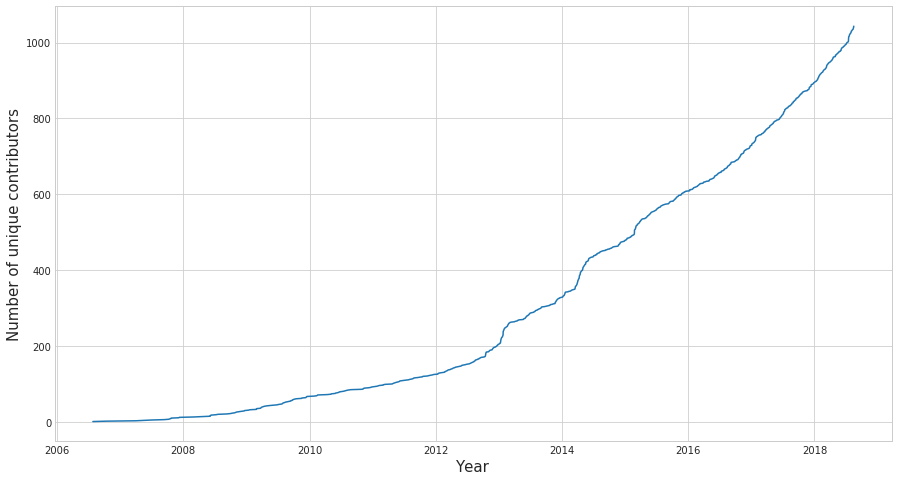

In [127]:
sns.set_style('whitegrid')
ax = unique_users_over_time.plot(x='date',y='cumulative',figsize=(15,8),legend=None)
ax.set_ylabel('Number of unique contributors', fontsize=15);
ax.set_xlabel('Year', fontsize=15)

In [96]:
df.head(3)

,id,type,amenity,highway,building,length,area,newName,user,version,minorVersion,validSince,validUntil,center,date
0,1470986380,node,NaN,NaN,NaN,NaN,NaN,NaN,Alexander Roalter,1,NaN,1318875166,NaN,"-94.4311988,48.7002426",2011-10-17
1,62577056,node,NaN,motorway_junction,NaN,NaN,NaN,NaN,DaveHansenTiger,1,NaN,1192000528,1.250244e+09,"-83.435511,42.38601",2007-10-10
2,62577056,node,NaN,motorway_junction,NaN,NaN,NaN,NaN,woodpeck_fixbot,2,NaN,1250243964,1.351533e+09,"-83.435511,42.38601",2009-08-14


# Where was editing done in detroit?

In [128]:
import shapely, json
from shapely import geometry
df.date.min() - datetime.date(2005,1,1)

datetime.timedelta(572)

In [134]:
for TYPE in ['building', 'highway','amenity','newName']:
    point_collection = {'type':'FeatureCollection','features':[]}
    for date, edits in df[df[TYPE].notnull()].groupby('date'):
        points = geometry.MultiPoint( edits.center.apply(lambda x: geometry.Point([float(y) for y in x.split(",")])).values )
        #print(json.dumps(geometry.mapping(points)))
        geojson = {
            'geometry':geometry.mapping(points),
            'type':"Feature",
            'properties': {'days_since_2005': (date - datetime.date(2005,1,1) ).days, 'edits':len(edits)}
        }
        point_collection['features'].append(geojson)

    json.dump(point_collection, open("../docs/data/"+PLACE+"-"+TYPE+"-points.geojson",'w'))

In [12]:
latest_versions = df.query("validUntil=={0}".format(TIME_NOW))

When were objects created in Detroit?

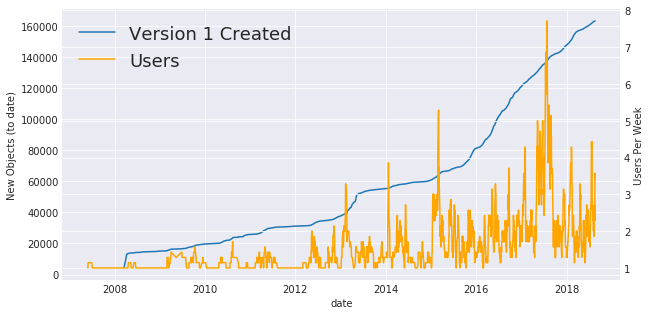

In [16]:
gb_dates = df.query('version==1').groupby('date').aggregate({'id':pd.Series.count, 'user': pd.Series.nunique})
sns.set_style("darkgrid"); axes = []
axes.append( gb_dates.id.cumsum().rolling(window=30).mean().plot(figsize=(10,5)) )
axes.append( gb_dates.user.rolling(window=7).mean().plot(figsize=(10,5), color='orange', ax=axes[0].twinx()) )
lines, labels = axes[0].get_legend_handles_labels()
for ax in axes[1:]:
    line, label = ax.get_legend_handles_labels()
    lines += line
axes[-1].legend(lines, ['Version 1 Created','Users'], loc=0, fontsize=18);
axes[0].set_ylabel('New Objects (to date)');
axes[1].set_ylabel('Users Per Week');

What about the latest edits to buildings?

In [322]:
gb_dates = latest_versions.groupby('date').aggregate({'id':pd.Series.count, 'user': pd.Series.nunique})

In [323]:
sns.set_style("darkgrid"); axes = []
axes.append( gb_dates.id.cumsum().rolling(window=30).mean().plot(figsize=(10,5)) )
axes.append( gb_dates.user.cumsum().rolling(window=30).mean().plot(figsize=(10,5), color='orange', ax=axes[0].twinx()) )
lines, labels = axes[0].get_legend_handles_labels()
for ax in axes[1:]:
    line, label = ax.get_legend_handles_labels()
    lines += line
axes[-1].legend(lines, ['Building Edits','Users'], loc=0, fontsize=18);
axes[0].set_ylabel('Building Count (to date)');
axes[1].set_ylabel('User Count (to date)');

TypeError: Empty 'DataFrame': no numeric data to plot

How long between building edits?

In [324]:
buildings.lifespan.hist()

AttributeError: 'DataFrame' object has no attribute 'lifespan'

# Versions

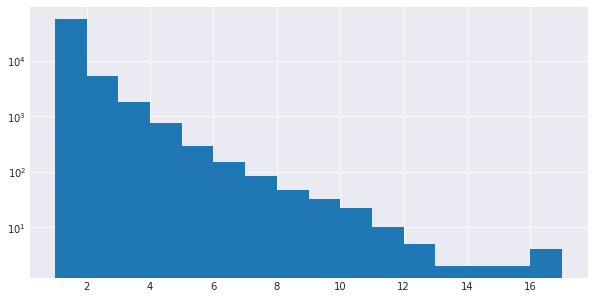

In [325]:
ax = buildings.version.hist(figsize=(10,5),bins=np.arange(1,buildings.version.max(),1))
ax.set_yscale('log')

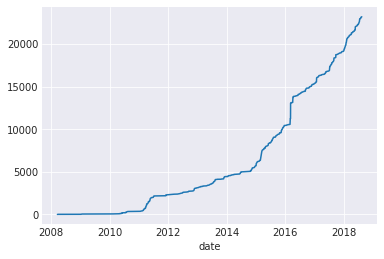

In [332]:
buildings.query('version>1').groupby('date').aggregate({'user':pd.Series.nunique, 'version':sum}).version.cumsum().plot()

In [244]:
buildings.sort_values(by='version', ascending=False)

,id,user,version,minVersion,validSince,validUntil,name,date,lifespan
2189376,190954764,amritkarma,315,0.0,1386477495,1535673544,NaN,2013-12-08,149196049
2189375,190954764,Manoj Thapa,314,0.0,1378293746,1386477495,NaN,2013-09-04,8183749
2189374,190954764,amritkarma,313,0.0,1373605537,1378293746,NaN,2013-07-12,4688209
2189373,190954764,Nepal-Mapper,312,0.0,1367394313,1373605537,NaN,2013-05-01,6211224
2189372,190954764,KTM-Mappers,311,0.0,1366648507,1367394313,NaN,2013-04-22,745806
2189371,190954764,KTM-Mappers,310,0.0,1366276801,1366648507,NaN,2013-04-18,371706
2189370,190954764,KTM-Mappers,309,0.0,1366276780,1366276801,NaN,2013-04-18,21
2189369,190954764,KTM-Mappers,308,0.0,1366276738,1366276780,NaN,2013-04-18,42
2189368,190954764,KTM-Mappers,307,0.0,1366276667,1366276738,NaN,2013-04-18,71
2189367,190954764,KTM-Mappers,306,0.0,1366276304,1366276667,NaN,2013-04-18,363


# Learning about Names

In [245]:
buildings_gb_date = buildings[buildings.name.notnull()].groupby('date')

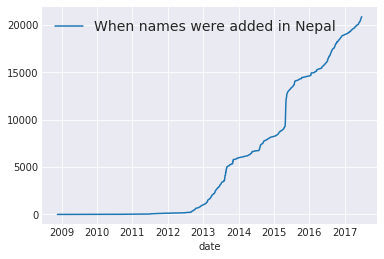

In [284]:
sns.set_style('darkgrid')
ax = buildings_gb_date.aggregate({'id':'nunique'}).cumsum().plot()
ax.legend(['When names were added in Nepal'],fontsize=14)

In [247]:
gb_dates = buildings.groupby('date').aggregate({'id':pd.Series.count, 'user': pd.Series.nunique, 'name':'count'})

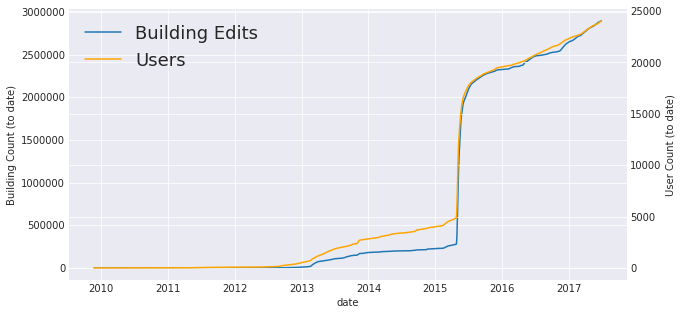

In [248]:
sns.set_style("darkgrid"); axes = []
axes.append( gb_dates.id.cumsum().rolling(window=7).mean().plot(figsize=(10,5)) )
axes.append( gb_dates.user.cumsum().rolling(window=7).mean().plot(figsize=(10,5), color='orange', ax=axes[0].twinx()) )
lines, labels = axes[0].get_legend_handles_labels()
for ax in axes[1:]:
    line, label = ax.get_legend_handles_labels()
    lines += line
axes[-1].legend(lines, ['Building Edits','Users'], loc=0, fontsize=18);
axes[0].set_ylabel('Building Count (to date)');
axes[1].set_ylabel('User Count (to date)');

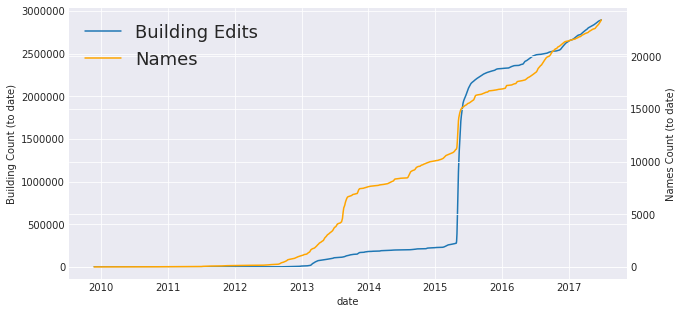

In [249]:
sns.set_style("darkgrid"); axes = []
axes.append( gb_dates.id.cumsum().rolling(window=7).mean().plot(figsize=(10,5)) )
axes.append( gb_dates.name.cumsum().rolling(window=7).mean().plot(figsize=(10,5), color='orange', ax=axes[0].twinx()) )
lines, labels = axes[0].get_legend_handles_labels()
for ax in axes[1:]:
    line, label = ax.get_legend_handles_labels()
    lines += line
axes[-1].legend(lines, ['Building Edits','Names'], loc=0, fontsize=18);
axes[0].set_ylabel('Building Count (to date)');
axes[1].set_ylabel('Names Count (to date)');


In [250]:
buildings.groupby('user').aggregate({'id':'nunique','version':'count','validSince':min,'validUntil':max}).sort_values(by='id',ascending=False)

,id,version,validSince,validUntil
user,,,,
Heinz_V,204121,205616,1424845209,1535673544
Alisha12,114439,120174,1467695745,1535673544
bookbugs,59825,59890,1430035223,1535673544
vichada,45355,45431,1430074413,1535673544
lja60,43933,44773,1430456189,1535673544
Manoj Thapa,43382,45259,1346217945,1535673544
Bishal9841,39041,40765,1458551731,1535673544
Geofreund1,34720,34980,1313697877,1535673544
abel801,33684,33754,1430166308,1535673544


# User Editing Network?

In [113]:
import networkx as nx

In [115]:
G = nx.DiGraph()
for line in open('../data/detroit-users.edgelist','r'):
    sourceLabel, targetLabel, weight = line.split(",")
    weight = int(weight)
    if weight > 15:
        G.add_edge(sourceLabel, targetLabel, weight=weight)

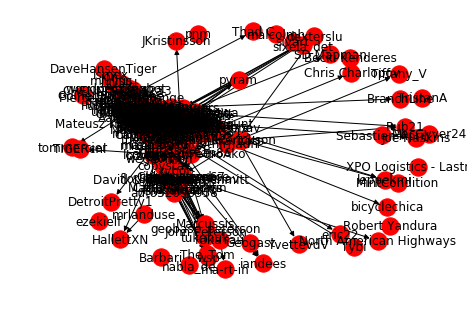

In [116]:
nx.draw_spring(G, with_labels=True)

In [260]:
nx.write_graphml(G,'/data/www/jennings/nepal_users.graphml');

In [261]:
gb_user = buildings.groupby('user').aggregate({'validSince':min, 'validUntil':max, 'version':'count','id':'nunique'})

In [268]:
gb_user['firstBuilding'] = gb_user.validSince.apply(lambda t: pd.Timestamp(t*1000000000).date())
gb_user['lastBuilding'] = gb_user.validUntil.apply(lambda t: pd.Timestamp(t*1000000000).date())

In [270]:
gb_user.head()

,validSince,validUntil,version,id,firstBuilding,lastBuilding
user,,,,,,
$agar11,1461967263,1535673544,7,6,2016-04-29,2018-08-30
+rama,1424001018,1424248590,1,1,2015-02-15,2015-02-18
-Christoph-,1429983843,1535673544,463,463,2015-04-25,2018-08-30
0109,1430289805,1431014646,1,1,2015-04-29,2015-05-07
048,1430455711,1535673544,40,40,2015-05-01,2018-08-30


Text(0.5,1,'Timespan of OSM Contributions to Buildings in Nepal')

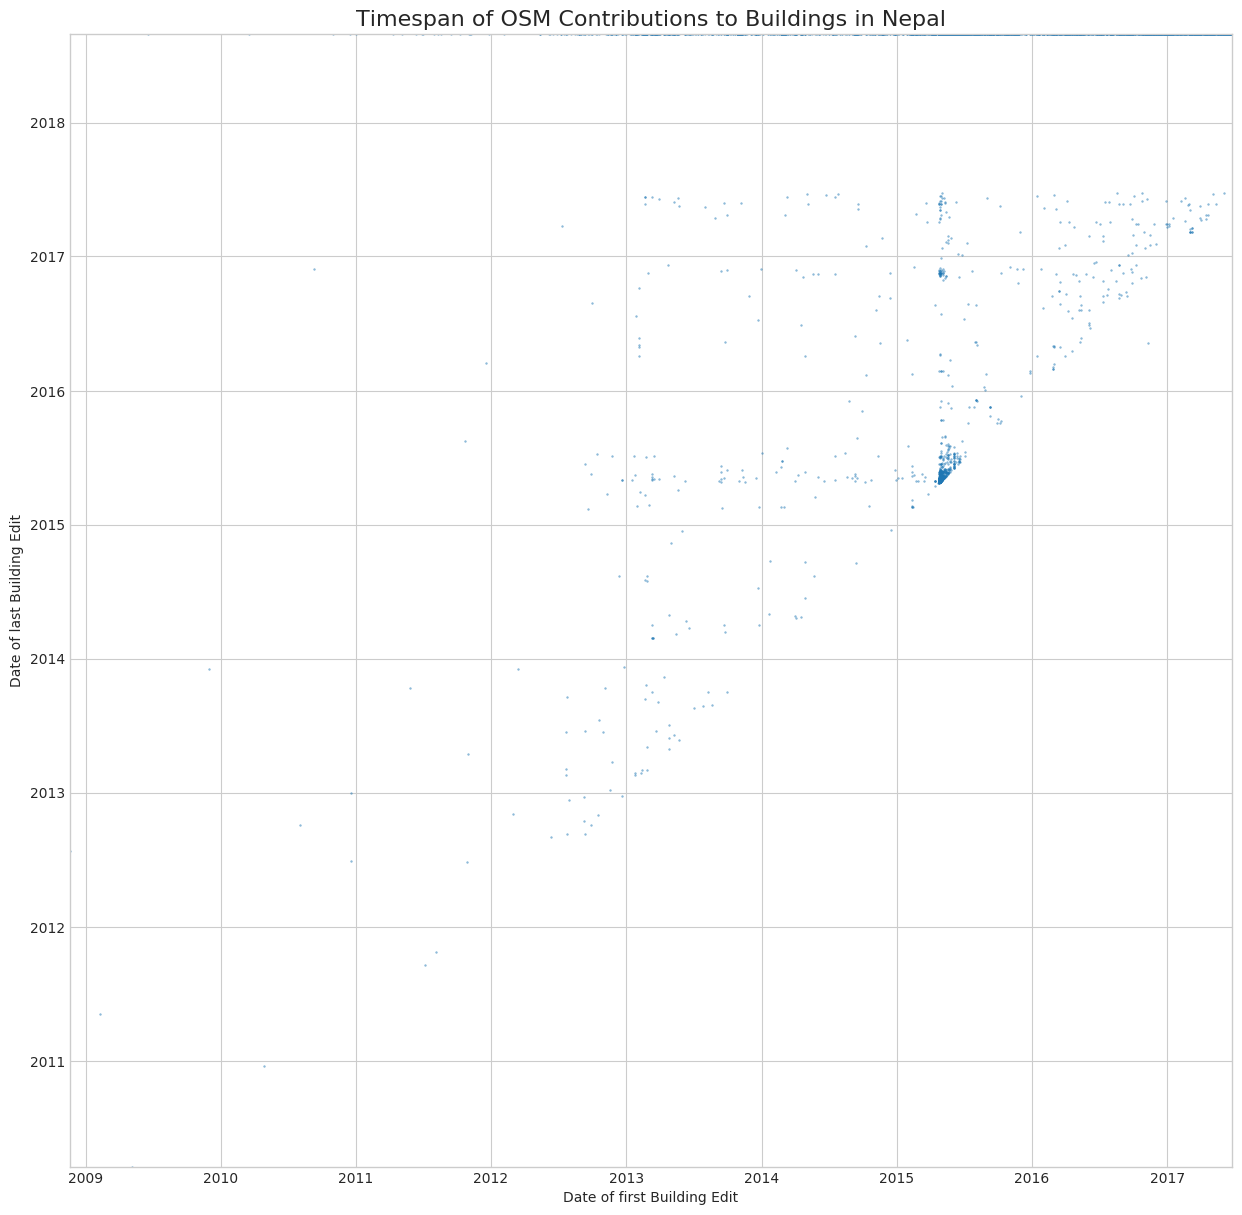

In [275]:
sns.set_style('whitegrid')
plt.figure(num=None, figsize=(15, 15), dpi=100, facecolor='w', edgecolor='k')
plt.plot(gb_user['firstBuilding'], gb_user['lastBuilding'], '+', markersize=2, alpha=0.5)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().yaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().yaxis.set_major_locator(mdates.YearLocator())
plt.xlim([gb_user.firstBuilding.min() , gb_user.firstBuilding.max()])
plt.ylim([gb_user.lastBuilding.min(), gb_user.lastBuilding.max()])
plt.xlabel('Date of first Building Edit')
plt.ylabel('Date of last Building Edit')
plt.title("Timespan of OSM Contributions to Buildings in Nepal",fontsize=16)
# plt.savefig('/data/www/jennings/osm-timespans.png')

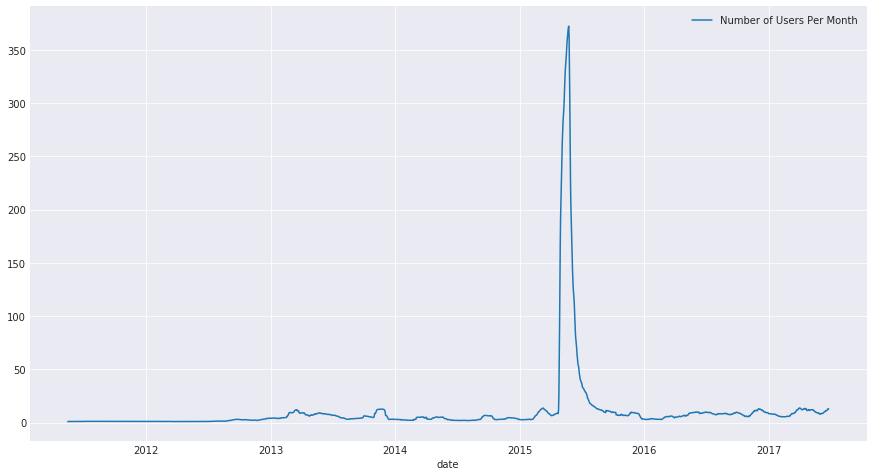

In [310]:
ax = gb_dates.user.rolling(30).mean().plot(figsize=(15,8))
ax.legend(["Number of Users Per Month"])

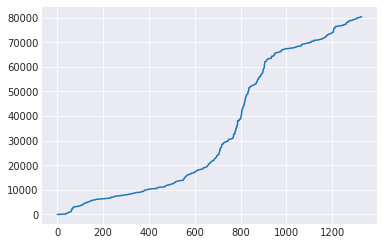

In [337]:
buildings.groupby('date',as_index=False).aggregate({'user':pd.Series.nunique, 'version':sum}).version.cumsum().plot()